### Data loading

In [256]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Read the file with automatic separator detection
data = pd.read_csv('data.txt', delim_whitespace=True)

# Separate the target variable (Y) from the predictors (X)
Y = data['y']
X = data.drop(columns=['y'])

C:\Users\polol\AppData\Local\Temp\ipykernel_9700\3193847137.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('data.txt', delim_whitespace=True)


### Definition of the RMSE function and calculation of the baseline RMSE value (RMSE for a constant prediction of y)

In [257]:
import numpy as np

# Define a function to calculate the Root Mean Square Error (RMSE)
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Calculate the baseline RMSE (assuming a constant prediction equal to the mean)
print("Baseline RMSE (std deviation of Y):", Y.std())

Baseline RMSE (std deviation of Y): 8.53123766184774


## Useful function definition

In [258]:

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Stratified K-Fold Cross-Validation with RMSE Calculation and Optional Transformation
def stratified_cross_val_rmse(
    model, X, Y, n_bins=6, n_splits=6, random_state=42, transform_func=None
):
    """
    Perform stratified k-fold cross-validation with RMSE calculation and optional transformation.

    Parameters:
    - model: The machine learning model to evaluate.
    - X: The predictors (DataFrame or NumPy array).
    - Y: The target variable (Pandas Series or NumPy array).
    - n_bins: Number of bins to create for stratification of Y.
    - n_splits: Number of folds for cross-validation.
    - random_state: Random state for reproducibility.
    - transform_func: Function to transform training and testing sets (e.g., adding quadratic terms).

    Returns:
    - rmse_scores: List of RMSE scores for each fold.
    - avg_rmse: Average RMSE across all folds.
    """
    y_binned = pd.qcut(Y, q=n_bins, labels=False)  # Quantile-based discretization
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rmse_scores = []

    for train_index, test_index in skf.split(X, y_binned):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        # Apply transformation if specified
        if transform_func:
            X_train = transform_func(X_train)
            X_test = transform_func(X_test)

        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(Y_test, predictions))
        rmse_scores.append(rmse)

    avg_rmse = np.mean(rmse_scores)
    return rmse_scores, avg_rmse


# Residual Plot for Regression Models
def plot_residuals(model, X, Y, transform_func=None, title="Residuals Plot"):
    """
    Plot the residuals of a regression model.

    Parameters:
    - model: Trained regression model.
    - X: Features (DataFrame or NumPy array).
    - Y: Target variable (Pandas Series or NumPy array).
    - transform_func: Function to transform X (optional).
    - title: Title for the residuals plot.
    """
    if transform_func:
        X = transform_func(X)

    predictions = model.predict(X)
    residuals = Y - predictions

    plt.figure(figsize=(10, 6))
    plt.scatter(predictions, residuals, alpha=0.7, color='blue')
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.title(title, fontsize=14)
    plt.xlabel("Predicted Values", fontsize=12)
    plt.ylabel("Residuals", fontsize=12)
    plt.grid(alpha=0.5)
    plt.show()

### Classical Linear Regression on Raw Data

Perform Linear Regression on raw data as a baseline to calculate RMSE

RMSE scores for each fold: [3.9110359053483514, 4.240546802042457, 3.604200491864096, 3.6804095407593533, 3.8304976228371546]
Average RMSE: 3.8533380725702826


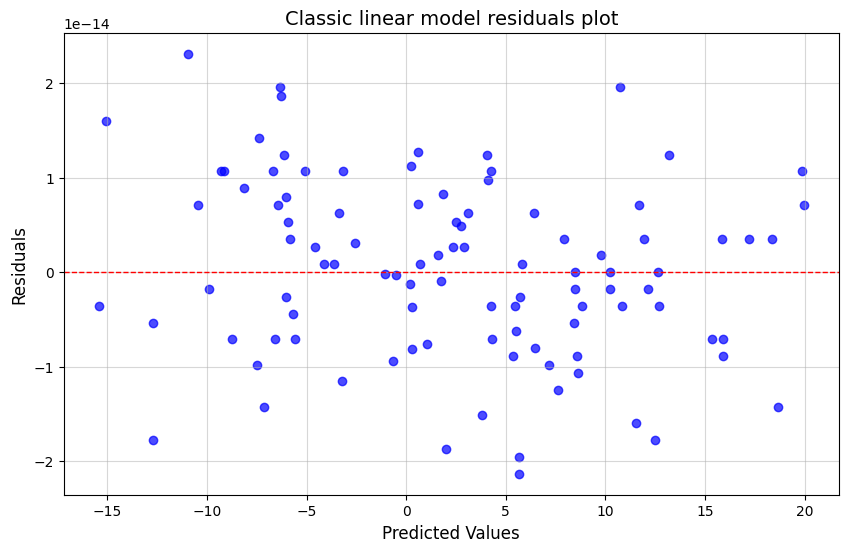

In [259]:
### Computation of RMSE for a classical regression model on raw data:
from sklearn.linear_model import LinearRegression

# Define the model
linear_model = LinearRegression()

# Perform stratified cross-validation and calculate RMSE scores
rmse_scores, avg_rmse = stratified_cross_val_rmse(linear_model, X, Y, n_bins=5, n_splits=5)

# Print RMSE scores for each fold and the average RMSE
print(f"RMSE scores for each fold: {rmse_scores}")
print(f"Average RMSE: {avg_rmse}")

linear_model.fit(X,Y)
# Generate a residuals plot for the Linear Regression model.
plot_residuals(linear_model, X, Y, title="Classic linear model residuals plot")

### Target Variable Analysis and Visualization

We plot some basic statistics and graphs of the target variable to identify potential specific patterns that could guide our model development approach

Descriptive statistics of Y:
count    100.000000
mean       2.332830
std        8.531238
min      -15.415300
25%       -5.608600
50%        2.446850
75%        8.510100
max       19.948200
Name: y, dtype: float64

Missing values in Y:
0



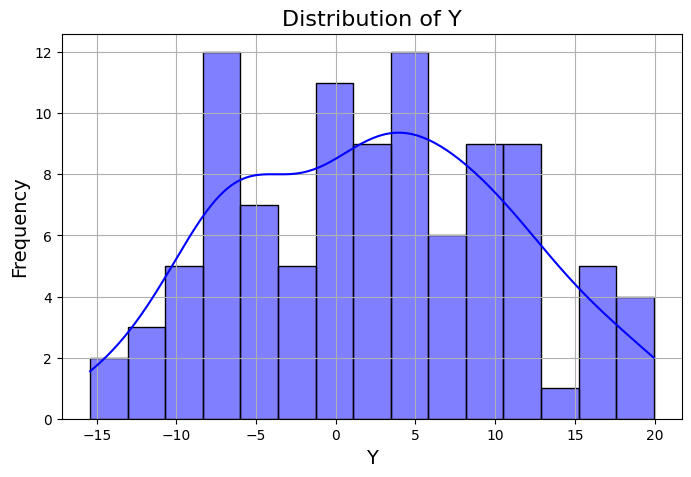

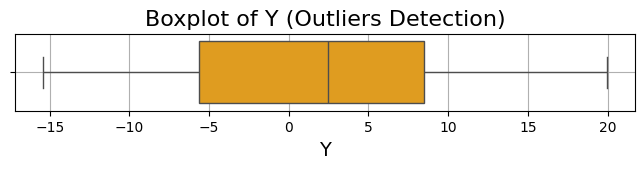

In [260]:
import matplotlib.pyplot as plt
import seaborn as sns

# Display descriptive statistics of the target variable (Y) to summarize its distribution.
print("Descriptive statistics of Y:")
print(Y.describe())
print()

# Check for missing values in the target variable to ensure data completeness.
print("Missing values in Y:")
print(Y.isnull().sum())
print()

# Plot the distribution of the target variable (Y) to visualize its overall shape and spread.
plt.figure(figsize=(8, 5))
sns.histplot(Y, kde=True, bins=15, color="blue")
plt.title("Distribution of Y", fontsize=16)
plt.xlabel("Y", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(True)
plt.show()

# Generate a boxplot of the target variable (Y) to detect potential outliers.
plt.figure(figsize=(8, 1))
sns.boxplot(x=Y, color="orange")
plt.title("Boxplot of Y (Outliers Detection)", fontsize=16)
plt.xlabel("Y", fontsize=14)
plt.grid(True)
plt.show()


We can see that Y does not have any outliers. Its distribution appears to be bi-Gaussian with means around -5 and 3.
There is nothing particularly notable about the target variable.

### Predictors statistics and visualisation

We perform the same analysis as for the target variable, plotting basic statistics and graphs of the features. The objective is to obtain a global understanding of the dataset structure and ensure that no significant information is overlooked

Target dimensions (Y): (100,), Predictors dimensions (X): (100, 200)
Total missing values in X: 0

Key statistics for each predictor:
      count      mean       std     min       25%      50%       75%     max
X1    100.0 -0.035051  1.359068 -3.4291 -0.867575  0.15115  1.053475  2.3887
X2    100.0 -0.078354  0.984814 -2.2972 -0.774175  0.01460  0.539800  2.4131
X3    100.0  0.150572  1.069848 -2.8344 -0.510475  0.17915  0.806425  2.4918
X4    100.0 -0.015394  1.282862 -2.6529 -0.900700  0.04170  0.955075  3.0085
X5    100.0 -0.051926  0.936731 -2.5628 -0.619250 -0.10645  0.547525  2.5337
X6    100.0 -0.039884  0.821642 -2.0634 -0.530450 -0.08175  0.609425  1.9893
X7    100.0  0.059076  0.920917 -1.9322 -0.755475  0.06870  0.673400  2.3240
X8    100.0  0.114772  0.980563 -2.1004 -0.557450  0.13475  0.836800  2.6025
X9    100.0  0.190370  1.187863 -2.3275 -0.716625  0.14930  0.971675  2.8503
X10   100.0  0.190691  1.103915 -2.9258 -0.598525  0.04675  0.860350  2.9476
X11   100.0  0.0220

C:\Users\polol\AppData\Local\Temp\ipykernel_9700\1413111050.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=outliers_X.index, y=outliers_X.values, palette="viridis")


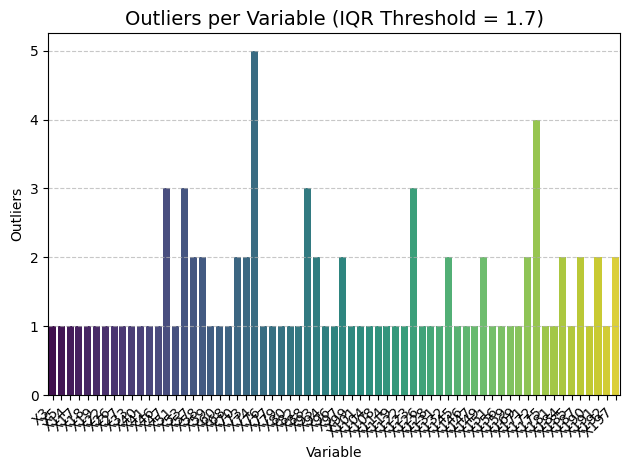

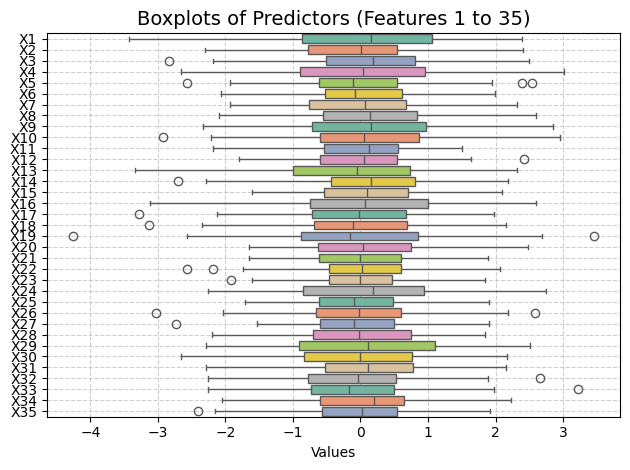

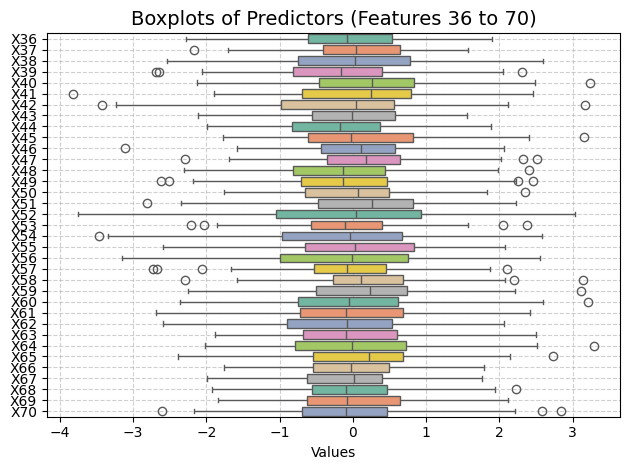

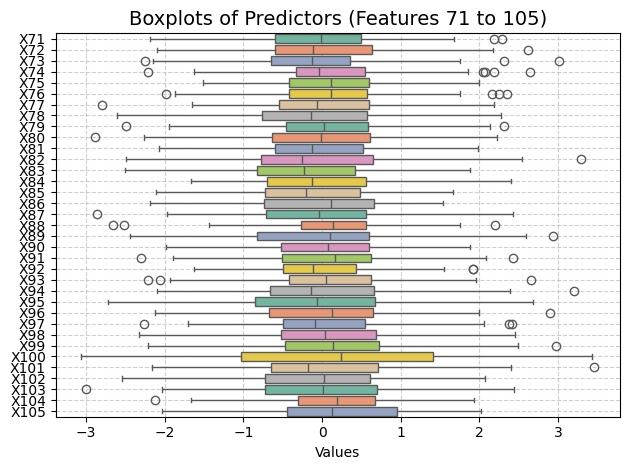

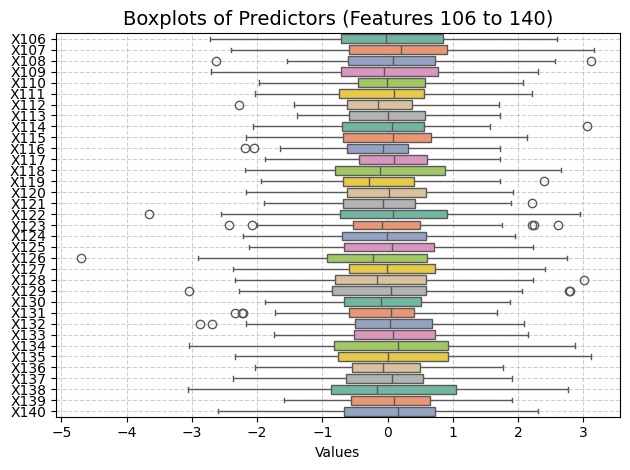

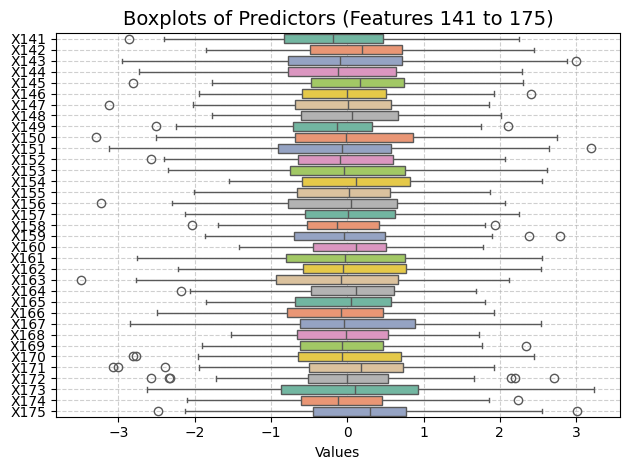

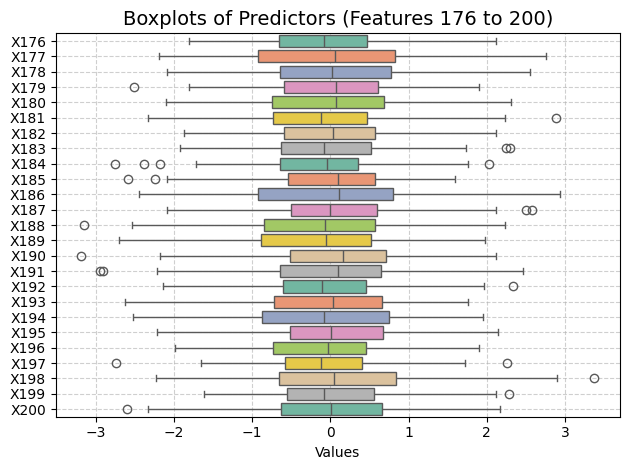

In [261]:
# Adjust pandas display settings to ensure all rows and columns are visible
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 1000)  

# Display basic dataset information to get a general overview
print(f"Target dimensions (Y): {Y.shape}, Predictors dimensions (X): {X.shape}")

# Check for missing values in the predictors
print(f"Total missing values in X: {X.isnull().sum().sum()}\n")

# Display essential statistics for each feature
print("Key statistics for each predictor:")
print(X.describe().T, "\n")

# Outlier detection using the Interquartile Range (IQR) method
def detect_outliers_summary(data, threshold=1.5):
    Q1, Q3 = data.quantile(0.25), data.quantile(0.75)
    IQR = Q3 - Q1
    bounds = (Q1 - threshold * IQR, Q3 + threshold * IQR)
    mask = (data < bounds[0]) | (data > bounds[1])
    return mask.sum()[mask.sum() > 0], mask.any(axis=1).sum()

outliers_X, total_points_with_outliers = detect_outliers_summary(X, threshold=1.7)
print(f"Total rows with at least one outlier: {total_points_with_outliers}/{X.shape[0]}")

if not outliers_X.empty:
    sns.barplot(x=outliers_X.index, y=outliers_X.values, palette="viridis")
    plt.title("Outliers per Variable (IQR Threshold = 1.7)", fontsize=14)
    plt.xlabel("Variable"), plt.ylabel("Outliers"), plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7), plt.tight_layout(), plt.show()
else:
    print("No outliers detected in any variable.")

# Plot boxplots for feature distributions
chunk_size = 35
for i in range(0, X.shape[1], chunk_size):
    subset = X.iloc[:, i:i + chunk_size]
    sns.boxplot(data=subset, orient='h', palette="Set2", showfliers=True)
    plt.title(f"Boxplots of Predictors (Features {i + 1} to {min(i + chunk_size, X.shape[1])})", fontsize=14)
    plt.xlabel("Values"), plt.grid(True, linestyle="--", alpha=0.6), plt.yticks(fontsize=10)
    plt.tight_layout(), plt.show()



Using boxplots, we observe numerous outliers in this dataset (more than half of the samples have at least one outlier among their coordinates). Given the small size of the dataset (only 100 samples), removing these outliers at this stage may not be appropriate, as it could lead to a significant loss of valuable information


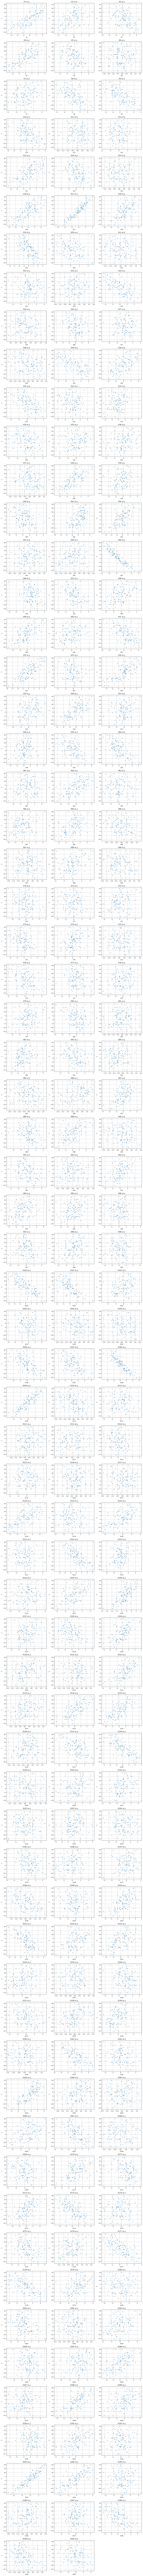

In [262]:
### Plot each variable against the target variable (y)
# List of explanatory variables
features = X.columns

# Define the number of columns and rows for the subplots
n_features = len(X)
n_cols = 3  # Number of columns per figure
n_rows = int(np.ceil(len(features) / n_cols))

# Figure size (adjust as needed)
plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, feature in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.scatterplot(x=X[feature], y=Y, alpha=0.5)
    plt.title(f'{feature} vs y')
    plt.xlabel(feature)
    plt.ylabel('y')
    plt.grid(True)

plt.tight_layout()
plt.show()

For most features, we observe a correlation with the target variable. For instance, features like 98 and 97 exhibit strong linear relationships with Y. Further analysis of feature correlations with the target variable will help determine whether and how to remove certain features.

### Correlation of predictors with the target variable

The dataset contains twice as many features as samples, which could lead to significant challenges related to collinearity and overfitting. Reducing the dimensionality of the dataset is therefore essential. As a first step, we will analyze the correlations between the features and \(y\) to identify and remove obviously irrelevant features.

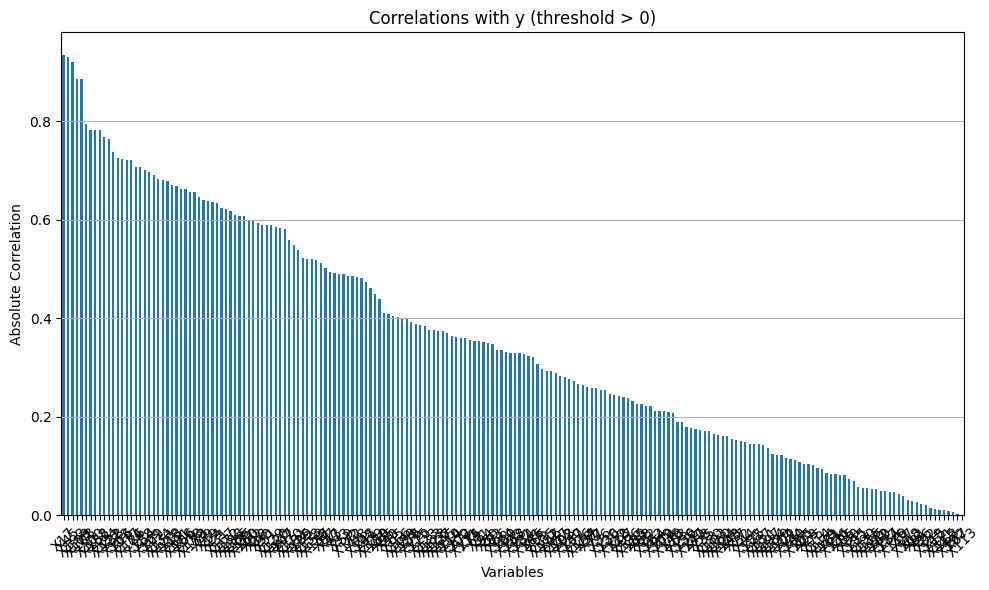

In [263]:
# Set a threshold for filtering correlations to be plotted
corr_threshold = 0 

# Compute the correlation matrix for predictors
correlations = X.corr() 

# Extract and sort the absolute correlations of the target variable (y) with predictors
correlations = data.corr()['y'].drop('y').abs().sort_values(ascending=False)

# Filter correlations that are greater than the specified threshold
correlations = correlations[correlations > corr_threshold]

# Plot the correlations that meet the threshold
plt.figure(figsize=(10, 6))
correlations.plot(kind='bar', title=f"Correlations with y (threshold > {corr_threshold})")
plt.ylabel("Absolute Correlation")
plt.xlabel("Variables")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add horizontal gridlines for clarity
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


Interpretation

The variables exhibit a broad spectrum of correlation values with the target variable y, ranging from high (around 0.8) to low (approaching 0). However, the distribution of correlations appears relatively uniform across this range. This makes it difficult to identify a clear threshold or "breakpoint" to effectively reduce the dimensionality of the dataset.

### Partial Least Squares Regression

To reduce dataset dimensionality and collinearity, we apply a regression method designed for this purpose. Partial Least Squares (PLS) Regression is particularly well-suited, as it effectively reduces the dataset's dimensionality while generating decorrelated features.

As a start we visualize PLS components covarinaces with y to decide how many we will use for regression

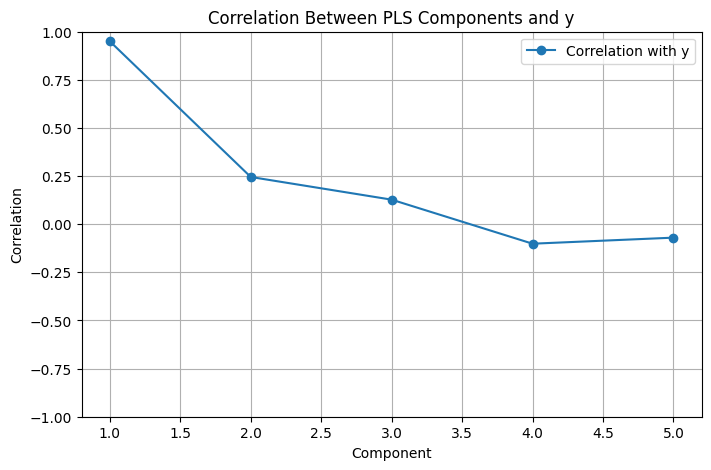

In [264]:
from sklearn.cross_decomposition import PLSRegression

# Normalize the dataset to standardize predictors
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X)

# Convert the scaled NumPy array back to a DataFrame, preserving the original column names
predictors_scaled = pd.DataFrame(X_scaled_array, columns=X.columns)

# Initialize and fit the Partial Least Squares (PLS) model
n_components = 5  # Specify the maximum number of components to evaluate
pls_model = PLSRegression(n_components=n_components)
pls_model.fit(predictors_scaled, Y)  # Fit the PLS model to the scaled predictors and target variable

# Extract the latent components (scores) from the fitted PLS model
latent_components = pls_model.x_scores_

# Calculate the correlation between each latent component and the target variable (Y)
correlations = [np.corrcoef(latent_components[:, i], Y.squeeze())[0, 1] for i in range(latent_components.shape[1])]

# Plot the correlations between the latent components and the target variable
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components + 1), correlations, marker='o', label="Correlation with y")
plt.title("Correlation Between PLS Components and y") 
plt.xlabel("Component") 
plt.ylabel("Correlation")  
plt.ylim(-1, 1)  # Correlations are bounded between -1 and 1
plt.grid()
plt.legend() 
plt.show()


We observe that the first 5 components show a strong correlation with the target variable y. It seems appropriate to select only these components to reduce the dimensionality of the dataset and perform linear regression on them. However, after several tests, we notice that the model achieves significantly better performance when using only the first component. This is likely because the subsequent components introduce noise and lead to overfitting. Therefore, we continue selecting only the first component for PLS

RMSE scores for each fold: [3.1850713408019056, 2.7945596363130667, 2.8180741183704248, 2.7005777703813094, 2.375244917892743]
Average RMSE: 2.7747055567518903


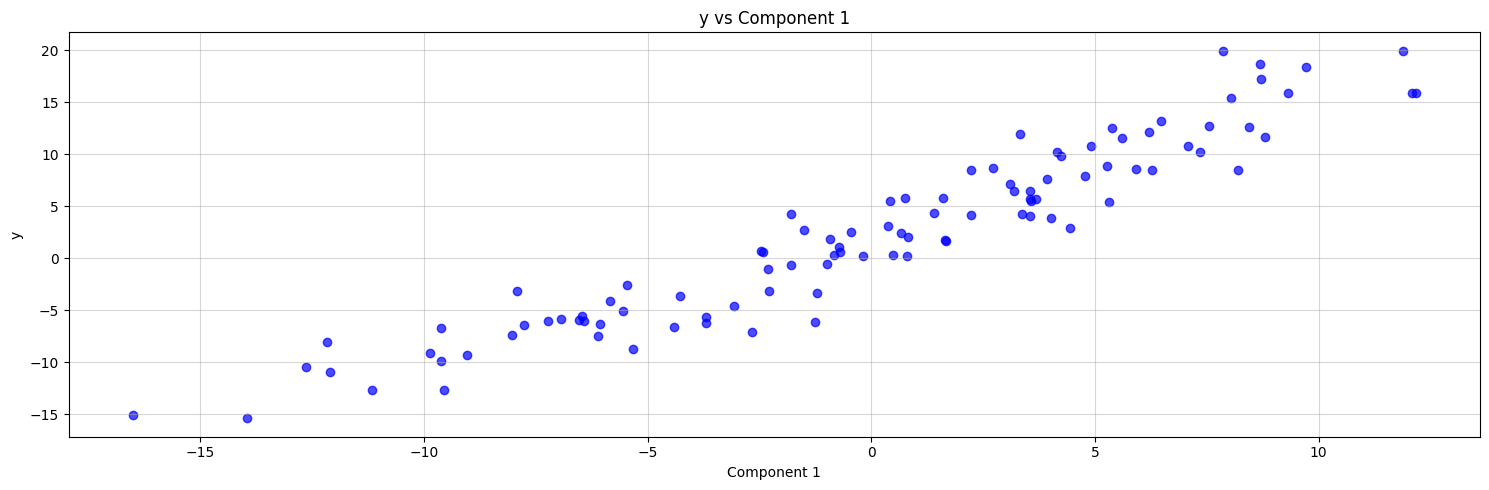

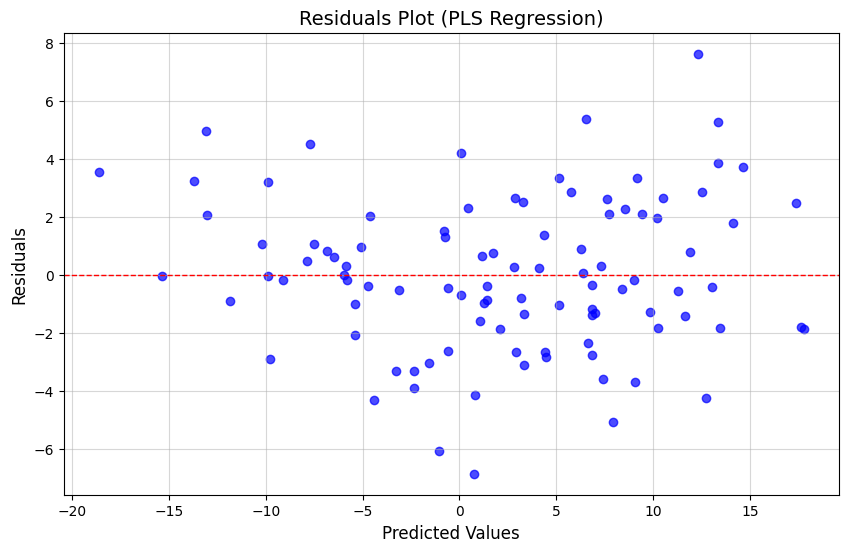

In [265]:

# Define the number of components for PLS
n_components = 1  # Specify the number of components

# Initialize the PLS model
pls_model = PLSRegression(n_components=n_components)

# Perform stratified cross-validation
rmse_scores, avg_rmse = stratified_cross_val_rmse(pls_model, X, Y, n_bins=5, n_splits=5)

# Display results
print(f"RMSE scores for each fold: {rmse_scores}")
print(f"Average RMSE: {avg_rmse}")

# Refit the model on the entire dataset to get latent components
pls_model.fit(X, Y)
latent_components = pls_model.x_scores_

# Plot y against each latent component
plt.figure(figsize=(15, 5))
for i in range(n_components):
    plt.subplot(1, n_components, i + 1)
    plt.scatter(latent_components[:, i], Y, alpha=0.7, color='blue')
    plt.title(f"y vs Component {i + 1}", fontsize=12)
    plt.xlabel(f"Component {i + 1}", fontsize=10)
    plt.ylabel("y", fontsize=10)
    plt.grid(alpha=0.5)

plt.tight_layout()
plt.show()

# Refit the PLS model on the entire dataset
pls_model.fit(X, Y)

# Plot residuals
plot_residuals(pls_model, X, Y, title="Residuals Plot (PLS Regression)")


We achieved a significant improvement in the RMSE score. However, we observed a quadratic trend in the residual series. To address this issue, we will introduce new quadratic predictors to capture this pattern and further refine the model.


RMSE scores for each fold: [3.601291487255595, 1.9374174870728083, 3.3425943338854816, 2.322422773244003, 2.282446457860033, 2.750571972191371, 1.8814397321440965, 3.3861095059928443, 2.1410362992352323, 3.0251787481761077]
Average RMSE: 2.6670508797057573


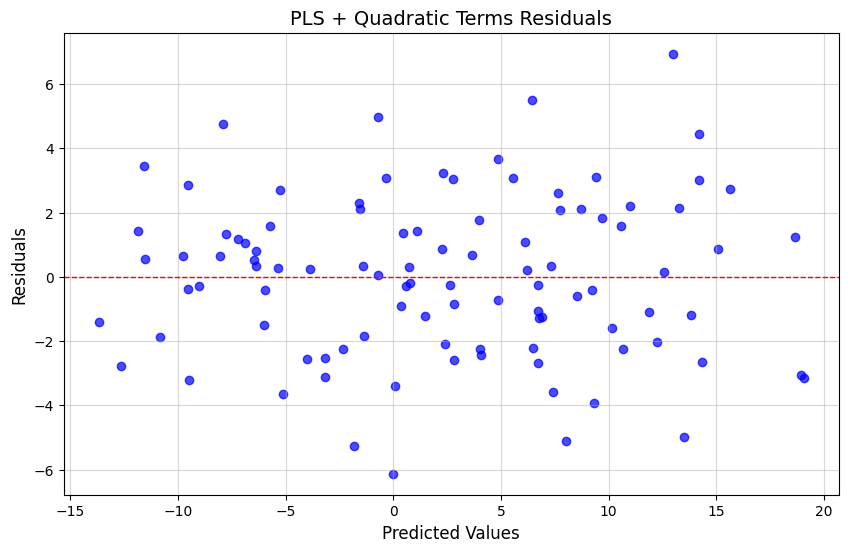

In [266]:
# Define parameters for PLS and cross-validation
n_components = 1  # Number of components for PLS
n_bins, n_splits, random_state = 5, 10, 42  # Cross-validation settings
rmse_scores = []  # List to store RMSE scores

# Bin the target variable for stratified cross-validation
y_binned = pd.qcut(Y, q=n_bins, labels=False)

# Perform stratified K-fold cross-validation
for train_index, test_index in StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state).split(X, y_binned):
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Train PLS model on training data
    pls_model = PLSRegression(n_components=n_components).fit(X_train, Y_train)
    latent_train, latent_test = pls_model.transform(X_train), pls_model.transform(X_test)  # Transform data

    # Add quadratic and cubic terms to latent components
    latent_train_expanded = np.hstack([latent_train, latent_train**2, latent_train**3])
    latent_test_expanded = np.hstack([latent_test, latent_test**2, latent_test**3])

    # Train linear regression on expanded latent components
    linear_model = LinearRegression().fit(latent_train_expanded, Y_train)

    # Predict and compute RMSE for the current fold
    predictions = linear_model.predict(latent_test_expanded)
    rmse_scores.append(np.sqrt(mean_squared_error(Y_test, predictions)))

# Calculate and display average RMSE across all folds
avg_rmse = np.mean(rmse_scores)
print(f"RMSE scores for each fold: {rmse_scores}")
print(f"Average RMSE: {avg_rmse}")

# Refit the PLS model on the entire dataset for residual analysis
pls_model.fit(X, Y)
latent_components = pls_model.transform(X)
latent_components_expanded = np.hstack([latent_components, latent_components**2, latent_components**3])

# Train the linear model on the full dataset
linear_model.fit(latent_components_expanded, Y)

# Plot residuals of the final model
def plot_residuals(model, X, Y, title="Residuals Plot"):
    predictions = model.predict(X)
    residuals = Y - predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(predictions, residuals, alpha=0.7, color='blue')
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.title(title, fontsize=14)
    plt.xlabel("Predicted Values", fontsize=12)
    plt.ylabel("Residuals", fontsize=12)
    plt.grid(alpha=0.5)
    plt.show()

plot_residuals(linear_model, latent_components_expanded, Y, title="PLS + Quadratic Terms Residuals")




We have improved the RMSE, and the residuals now resemble random noise. This is a positive outcome, indicating that the model captures most of the systematic variance in the data

We will now explore new methods to further improve our model. We will apply Elastic Net Regression as it serves as an 'all-in-one package.' Specifically, it allows us to:
- Perform regularization, which is essential given the 200 predictors that lead to overfitting and likely collinearity.
- Enable feature selection, which helps reduce the dimensionality of the dataset while eliminating noise and collinearity.

Add quadratic terms to the dataset to address the residual patterns observed in the previous model

In [267]:
from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial features (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)  # Create normal and quadratic terms
num_features = X.shape[1]  # Number of original features

Normalization

In [268]:
# Normalize the dataset
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X_poly)  # Returns a NumPy array

# Convert the NumPy array back to a DataFrame while preserving column names
X_poly_scaled = pd.DataFrame(X_scaled_array)

### Optimization of Elastic Net Regression Parameters

Progress: 100.00%
Best Alpha: 1.000
Best L1_Ratio: 1.000
Minimum RMSE: 2.8216


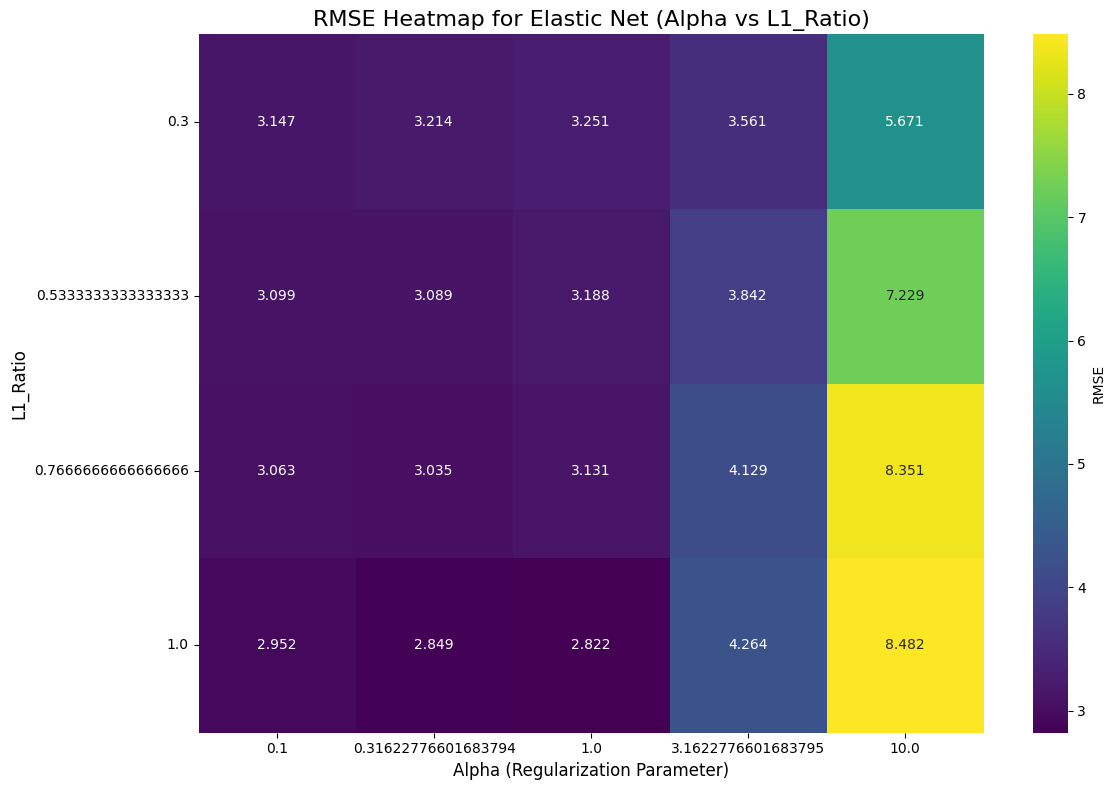

In [269]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import ParameterGrid
import warnings
from sklearn.exceptions import ConvergenceWarning
import sys

# Suppress specific warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Define regularization parameters and grid
alphas = np.logspace(-1, 1, 5)
l1_ratios = np.linspace(0.3, 1, 4)
param_grid = ParameterGrid({'alpha': alphas, 'l1_ratio': l1_ratios})

# Initialize progress tracking and results storage
results = []
total_params = len(param_grid)

# Evaluate combinations of parameters
for c, params in enumerate(param_grid, 1):
    alpha, l1_ratio = params['alpha'], params['l1_ratio']
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
    _, avg_rmse = stratified_cross_val_rmse(model, X_poly_scaled, Y, n_bins=5, n_splits=5)
    results.append((alpha, l1_ratio, avg_rmse))
    
    # Real-time progress display
    sys.stdout.write(f"\rProgress: {c / total_params:.2%}")
    sys.stdout.flush()

# Convert results to DataFrame and find best parameters
results_df = pd.DataFrame(results, columns=['Alpha', 'L1_Ratio', 'RMSE'])
best_row = results_df.loc[results_df['RMSE'].idxmin()]
print(f"\nBest Alpha: {best_row['Alpha']:.3f}")
print(f"Best L1_Ratio: {best_row['L1_Ratio']:.3f}")
print(f"Minimum RMSE: {best_row['RMSE']:.4f}")

# Plot RMSE heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    results_df.pivot_table(index='L1_Ratio', columns='Alpha', values='RMSE'),
    annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'RMSE'}
)
plt.title("RMSE Heatmap for Elastic Net (Alpha vs L1_Ratio)", fontsize=16)
plt.xlabel("Alpha (Regularization Parameter)", fontsize=12)
plt.ylabel("L1_Ratio", fontsize=12)
plt.tight_layout()
plt.show()




We observe that the optimal parameters for ElasticNet correspond to an l1_ratio = 1, which indicates that the best-performing model is essentially a Lasso Regression. This is likely due to the high number of features and the model's inability to perform effective feature selection. The combination of l1 and l2 regularization dilutes the effect of l1's strict variable selection. Therefore, we will proceed with a standard Lasso Regression model.

### Lasso Regression

After conducting several tests, we observe that the Lasso model is still unable to achieve effective feature selection, retaining approximately 80 features. Additionally, the residual series exhibits some quadratic patterns. To address this, we include a feature selector (SelectKBest) in the pipeline prior to the Lasso regression to improve the model's feature selection. This approach results in better RMSE performance.

RMSE scores for each fold: [3.3744564159434547, 2.284224281265151, 2.870008456034538, 1.916872948682354, 2.7289551054029184, 3.063054506389981, 1.4551037772516309, 2.3703523387512906, 2.3605236267207963, 2.181156356444924]
Average RMSE: 2.460470781288704
Number of Variables Kept by the Lasso Model: 4


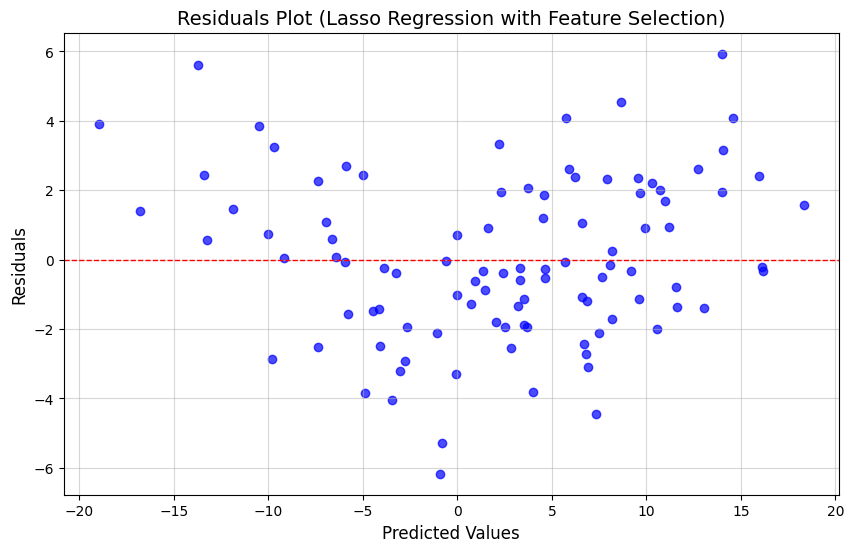

In [270]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline


# Set the number of top features to select for the model
k = 5  # You can adjust this value based on the dataset

# Define the pipeline with feature selection and Lasso regression
pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_regression, k=k)),  # Feature selection
    ('lasso', Lasso(alpha=0.1, random_state=42))  # Lasso regression
])

# Perform stratified cross-validation with feature selection and Lasso
rmse_scores, avg_rmse = stratified_cross_val_rmse(
    pipeline, X_poly_scaled, Y, n_bins=5, n_splits=10
)

# Display results
print(f"RMSE scores for each fold: {rmse_scores}")
print(f"Average RMSE: {avg_rmse}")

# Fit the pipeline on the entire dataset
pipeline.fit(X_poly_scaled, Y)

# Calculate the number of non-zero coefficients from Lasso
non_zero_coefficients = np.sum(pipeline.named_steps['lasso'].coef_ != 0)
print(f"Number of Variables Kept by the Lasso Model: {non_zero_coefficients}")

# Plot residuals using the pipeline
plot_residuals(pipeline, X_poly_scaled, Y, title="Residuals Plot (Lasso Regression with Feature Selection)")


We observe here that beyond a major improvement ins RMSE score, a strong patern stands out in the residuals. We understand that the features selector operates a rough data selection oriented by the improvement of the RMSE score. However ths selection remove all the quadratic features we added to keep only some highly correlated original features. This selection seems to push the model to overfitting. That's why we observe quadratic tendency in residuals. 

To address this issue, we perform a separate selection of quadratic and normal features, creating new feature subsets that are balanced between quadratic and non-quadratic components. Additionally, to mitigate overfitting as observed earlier, we revert to using ElasticNet.

### ElasticNet with Separate Selection of Quadratic and Non-Quadratic Features

RMSE scores for each fold: [3.226015595425813, 2.6602695936481493, 2.6418018150299227, 2.2641550308249965, 2.450120851144207, 2.2108704095223852, 1.223451705252386, 2.6600081683621597, 2.0645340068932123, 2.045034529553369]
Average RMSE: 2.34462617056566
Number of Variables Kept by the Elastic Net Model: 18


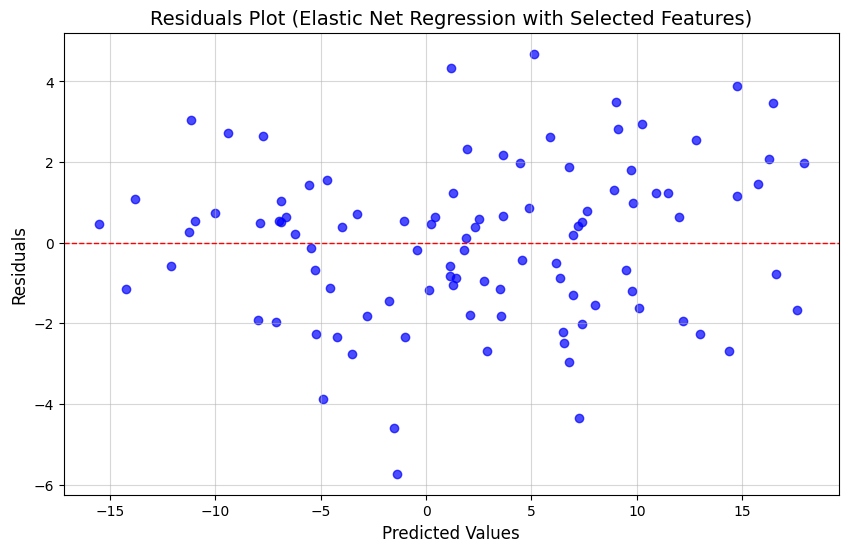

In [271]:
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import numpy as np
import pandas as pd

# Generate polynomial features (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)  # Create normal and quadratic terms
num_features = X.shape[1]  # Number of original features



# Define a custom transformation function for normal and quadratic feature selection
def select_normal_and_quadratic_features(X, Y, num_features):
    """
    Select top 10 normal and top 10 quadratic features independently.

    Parameters:
    - X: Combined dataset of normal and quadratic features.
    - Y: Target variable.
    - num_features: Number of original (normal) features.

    Returns:
    - X_selected: Combined dataset of selected normal and quadratic features.
    - X_normal_selected_indices: Indices of selected normal features.
    - X_quadratic_selected_indices: Indices of selected quadratic features.
    """
    # Separate normal and quadratic features based on num_features
    X_normal = X[:, :num_features]  # Original features
    X_quadratic = X[:, num_features:]  # Quadratic and interaction terms

    # Select top 10 normal features
    selector_normal = SelectKBest(score_func = f_regression, k=5)
    selector_normal.fit(X_normal, Y)
    X_normal_selected_indices = selector_normal.get_support(indices=True)

    # Select top 10 quadratic features
    selector_quadratic = SelectKBest(score_func=f_regression, k=20)
    selector_quadratic.fit(X_quadratic, Y)
    X_quadratic_selected_indices = selector_quadratic.get_support(indices=True)

    # Combine selected normal and quadratic features
    X_selected = np.hstack([
        X[:, X_normal_selected_indices],                          # Normal features
        X[:, num_features + X_quadratic_selected_indices]         # Quadratic features (adjusted indices)
    ])

    return X_selected, X_normal_selected_indices, X_quadratic_selected_indices


# Define a pipeline that scales and applies Elastic Net regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalize features
    ('elasticnet', ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42))  # Elastic Net regression
])


# Modify stratified_cross_val_rmse to apply custom feature selection
def stratified_cross_val_rmse_with_custom_selection(model, X, Y, n_bins=5, n_splits=5, random_state=42):
    """
    Perform stratified k-fold cross-validation with RMSE calculation and custom feature selection.

    Parameters:
    - model: The machine learning model to evaluate.
    - X: The predictors (DataFrame or NumPy array).
    - Y: The target variable (Pandas Series or NumPy array).
    - n_bins: Number of bins to create for stratification of Y.
    - n_splits: Number of folds for cross-validation.
    - random_state: Random state for reproducibility.

    Returns:
    - rmse_scores: List of RMSE scores for each fold.
    - avg_rmse: Average RMSE across all folds.
    """
    y_binned = pd.qcut(Y, q=n_bins, labels=False)  # Quantile-based discretization
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rmse_scores = []

    for train_index, test_index in skf.split(X, y_binned):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        # Apply custom feature selection for each fold
        X_train_selected, X_normal_selected, X_quadratic_selected = select_normal_and_quadratic_features(X_train, Y_train, num_features)
        X_test_selected = np.hstack([
            X_test[:, X_normal_selected],                          # Normal features
            X_test[:, num_features + X_quadratic_selected]         # Quadratic features (adjusted indices)
        ])

        # Fit the model
        model.fit(X_train_selected, Y_train)

        # Predict and calculate RMSE
        predictions = model.predict(X_test_selected)
        rmse = np.sqrt(mean_squared_error(Y_test, predictions))
        rmse_scores.append(rmse)

    avg_rmse = np.mean(rmse_scores)
    return rmse_scores, avg_rmse


# Combine normal and quadratic features for cross-validation
X_combined = np.hstack([X_poly[:, :num_features], X_poly[:, num_features:]])

# Perform stratified cross-validation with custom feature selection
rmse_scores, avg_rmse = stratified_cross_val_rmse_with_custom_selection(
    pipeline, X_combined, Y.values, n_bins=5, n_splits=10
)

# Display results
print(f"RMSE scores for each fold: {rmse_scores}")
print(f"Average RMSE: {avg_rmse}")

# Apply custom feature selection to the entire dataset and fit the pipeline
X_selected, X_normal_selected_indices, X_quadratic_selected_indices = select_normal_and_quadratic_features(X_combined, Y, num_features)
pipeline.fit(X_selected, Y)

# Calculate the number of non-zero coefficients
non_zero_coefficients = np.sum(pipeline.named_steps['elasticnet'].coef_ != 0)
print(f"Number of Variables Kept by the Elastic Net Model: {non_zero_coefficients}")

# Plot residuals
plot_residuals(pipeline, X_selected, Y, title="Residuals Plot (Elastic Net Regression with Selected Features)")



With this solution, the residuals are distributed like noise, confirming that our model captures the quadratic patterns effectively and avoids overfitting. Additionally, we observe a slight improvement in the RMSE. We retain this model as it appears to be well-optimized.

## Prediction on the Final X_test 

In [272]:
# Read the file with automatic separator detection
X_test = pd.read_csv('Xtest.txt', delim_whitespace=True)

# Generate the same polynomial features (degree 2) without the bias term
X_test_poly = poly.transform(X_test)

# Combine normal and quadratic features for X_test
X_test_combined = np.hstack([
    X_test_poly[:, :num_features],        # Original features
    X_test_poly[:, num_features:]         # Quadratic and interaction features
])

# Select the same feature indices as those used for the model
X_test_selected = np.hstack([
    X_test_combined[:, X_normal_selected_indices],                      # Selected normal features
    X_test_combined[:, num_features + X_quadratic_selected_indices]     # Selected quadratic features (adjusted indices)
])

# Make predictions with the trained pipeline
Xtest_predictions = pipeline.predict(X_test_selected)

# Display or save the predictions
print(Xtest_predictions)

# Optional: Save the predictions to a CSV file
pd.DataFrame(Xtest_predictions, columns=['Predictions']).to_csv('predictions.txt', index=False)



[ -8.10061751   4.05215941  12.04987543  -9.32704936   7.33277235
   6.19932115  -1.90902895  -3.29064064  -0.38239001  -1.98554454
  -2.14785238  -3.50396956  -5.93638465   0.60131332  10.8358516
   1.06543403   0.68321614  -3.1239251   -4.39011628  22.01846254
   1.31936234  -1.40288893  -4.92938757   3.87280413  -2.06267251
  -9.04071991   8.33801553  -6.29964845   2.1107253   -5.47268175
   9.57959976  -2.57799961  -3.74449698  -1.54130033 -10.07905031
  -5.25782084 -10.00647165  -5.32335553  -2.56333906  -2.65054156
  15.70050289  -6.32966721  -3.37533959  -0.66869061  -7.94654292
  -3.24794128  -8.86028727 -10.99553567  -2.09492228   0.66183616
 -13.95158237  -0.25014655  -5.88343647  -6.99594388   1.18561125
   6.75355387  13.75575223  -4.97105934  16.84446382  -2.54247127
   8.14547006  26.11865588   2.65632273  -0.3417431   -0.69626997
  17.22516242  -6.56632165  13.45024284  10.84040534   5.82008579
   4.1960155   -3.01044326   0.30588814   6.69379078  17.35858281
   3.144714

C:\Users\polol\AppData\Local\Temp\ipykernel_9700\2601754023.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv('Xtest.txt', delim_whitespace=True)


We verify whether the predicted values are close to the actual Y values of the training set in terms of mean and standard deviation. This helps us identify potential errors in the predictions on the X_test dataset

Mean of Y in the training set: 2.33283
Standard deviation of Y in the training set: 8.488474296509354
Mean of predictions in the test set: 1.4117551344063082
Standard deviation of predictions in the test set: 8.35976844578537
Difference in means between predictions: 0.9210748655936918
Difference in standard deviations between predictions: 0.12870585072398377


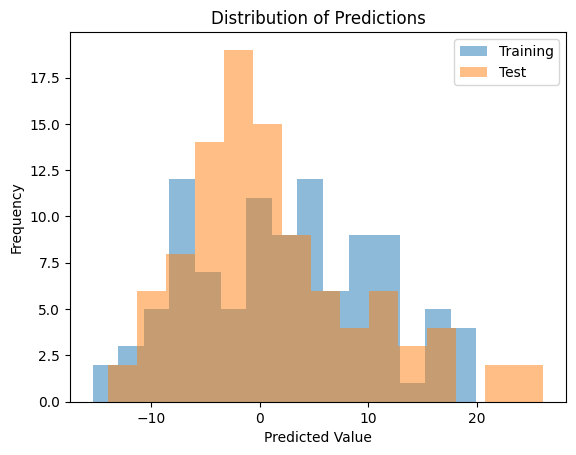

In [273]:


# Calculate statistics on predictions for the training set
train_mean = np.mean(Y)
train_std = np.std(Y)

print(f"Mean of Y in the training set: {train_mean}")
print(f"Standard deviation of Y in the training set: {train_std}")

# Calculate statistics on predictions for the test set
test_mean = np.mean(Xtest_predictions)
test_std = np.std(Xtest_predictions)

print(f"Mean of predictions in the test set: {test_mean}")
print(f"Standard deviation of predictions in the test set: {test_std}")

# Compare statistics between the training and test sets
print(f"Difference in means between predictions: {abs(train_mean - test_mean)}")
print(f"Difference in standard deviations between predictions: {abs(train_std - test_std)}")

# Visualize the distributions
import matplotlib.pyplot as plt

plt.hist(Y, bins=15, alpha=0.5, label='Training')
plt.hist(Xtest_predictions, bins=15, alpha=0.5, label='Test')
plt.legend()
plt.title('Distribution of Predictions')
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')
plt.show()


